In [1]:
%load_ext autoreload
%autoreload 2

import pygsti
from pygsti.modelpacks import smq1Q_XYI, smq2Q_XYCNOT
import numpy as np
from pprint import pprint
from experiment_helpers import make_depolarized_dataset, run_gst, corrupt_dataset, make_tweaked_dataset
from scipy import linalg as la
import pandas as pd
from pygsti.data.datasetconstruction import mix_datasets
from pygsti.report.plothelpers import rated_n_sigma

In [2]:
mp = smq1Q_XYI
target = mp.target_model()
fids = (mp.prep_fiducials(), mp.meas_fiducials())
germs = mp.germs()
maxmaxlen = 64
dsa, m_dga = make_tweaked_dataset(mp, depol_level=0.001, rand_unitary_scale=0.001, max_max_len=maxmaxlen)
dsb, m_dgb = make_tweaked_dataset(mp, depol_level=0.010, rand_unitary_scale=0.020, max_max_len=maxmaxlen)
mixture_weights = np.array([1, 0.99, 0.95, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.01, 0.0])
num_mixtures = mixture_weights.size

fit_mode = 'CPTPLND'
Lpnorm_spec = ('Lp^p', 10)
verb = 1

m_dga.convert_members_inplace(fit_mode)
m_dgb.convert_members_inplace(fit_mode)

In [3]:
reslist = []
for i,p in enumerate(mixture_weights):
    ds = mix_datasets(dsa, dsb, p)
    results = run_gst(ds, fids, germs, target, ['logl', 'normalized tvd', 'tvd', Lpnorm_spec], verbosity=verb, mode=fit_mode)
    reslist.append((results,ds))

--- Circuit Creation ---


-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --



/Users/rjmurr/Documents/pygsti-tvd/pygsti/pygsti/objectivefns/objectivefns.py:4055: UserWarning: This derivative is discontinuous and does not return a full subgradient.
  _warnings.warn('This derivative is discontinuous and does not return a full subgradient.')




--- Circuit Creation ---
-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --



--- Circuit Creation ---
-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --



--- Circuit Creation ---


/Users/rjmurr/Documents/pygsti-tvd/pygsti/pygsti/objectivefns/objectivefns.py:4557: RuntimeWarning: divide by zero encountered in divide
  p5over_lsvec = 0.5/lsvec


-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --



--- Circuit Creation ---
-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --



--- Circuit Creation ---
-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --



--- Circuit Creation ---
-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --





--- Circuit Creation ---
-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --



--- Circuit Creation ---


-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --



--- Circuit Creation ---


-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --





--- Circuit Creation ---
-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --



--- Circuit Creation ---
-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --



--- Circuit Creation ---
-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --




/Users/rjmurr/Documents/pygsti-tvd/pygsti/pygsti/optimize/customsolve.py:94: LinAlgWarning: Ill-conditioned matrix (rcond=3.1334e-17): result may not be accurate.
  x[:] = _scipy.linalg.solve(a, b, assume_a='pos')
/Users/rjmurr/Documents/pygsti-tvd/pygsti/pygsti/optimize/customsolve.py:94: LinAlgWarning: Ill-conditioned matrix (rcond=6.26613e-17): result may not be accurate.
  x[:] = _scipy.linalg.solve(a, b, assume_a='pos')
/Users/rjmurr/Documents/pygsti-tvd/pygsti/pygsti/optimize/customsolve.py:94: LinAlgWarning: Ill-conditioned matrix (rcond=4.10509e-18): result may not be accurate.
  x[:] = _scipy.linalg.solve(a, b, assume_a='pos')
/Users/rjmurr/Documents/pygsti-tvd/pygsti/pygsti/optimize/customsolve.py:94: LinAlgWarning: Ill-conditioned matrix (rcond=8.18734e-18): result may not be accurate.
  x[:] = _scipy.linalg.solve(a, b, assume_a='pos')



--- Circuit Creation ---
-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --



--- Circuit Creation ---
-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --





In [ ]:

dflists = []
for results, dsc in reslist:
    currdfs = []
    for ds in [dsa, dsc, dsb]:
        circuitlist = list(ds.cirIndex.keys())
        pvecs = []
        objectives = []
        Nsigs = []
        for estname, est in results.estimates.items():
            model = est.models['stdgaugeopt']
            try:
                Nsig, _ = rated_n_sigma(ds, model, circuitlist, 'logl')
            except Exception:
                Nsig = np.NaN
            Nsigs.append(Nsig)
            objective = est.final_objective_fn()
            objective.dataset = ds
            objective.add_count_vectors(force=True)
            objective.add_omitted_freqs(force=True)
            objectives.append(objective)
            pvecs.append(est.models['final iteration estimate'].to_vector())
        Nsigs.append(rated_n_sigma(ds, m_dga, circuitlist, 'logl')[0])
        Nsigs.append(rated_n_sigma(ds, m_dgb, circuitlist, 'logl')[0])
        Nsigs = np.array(Nsigs).reshape((-1,1))

        objvals = np.zeros((len(pvecs)+2, len(objectives)))
        for j,objective in enumerate(objectives):
            for i,pvec in enumerate(pvecs):
                val = objective.fn(pvec, stateless=True)
                objvals[i,j] = val
            objvals[i+1,j] = objective.fn_from_model(m_dga)
            objvals[i+2,j] = objective.fn_from_model(m_dgb)
        objvals = np.concatenate((objvals, Nsigs), axis=1)

        df = pd.DataFrame(
            objvals,
            index=['argmin(LogL)', 'argmin(nTVD)', 'argmin(TVD)', 'argmin(L10^10)', 'Model A', 'Model B'],
            columns=['LogL', 'nTVD', 'TVD', 'L10', 'N_sigma'],
        )
        df.rename_axis(index='model')
        currdfs.append(df)
    dflists.append(currdfs)


In [5]:
dflist = []
for dfl in dflists:
    dfa, df, dfb = dfl
    temp = dfa.join(df, lsuffix='(A)', rsuffix='(mix)')
    dfb = dfb.copy()
    dfb.columns = dfb.columns.map(lambda x: str(x) + '(B)')
    temp = temp.join(dfb)
    temp = temp.sort_index(axis=1)
    for colname in ['L10(A)', 'L10(B)', 'L10(mix)']:
        temp[colname] = temp[colname]**0.1
    dflist.append(temp)

pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 300)
for i,df in enumerate(dflist):
    print( '\n' + 250*'-')
    p = mixture_weights[i]
    print(f'\nThe mixture dataset had weight {p:1.2f} on dataset A and weight {1-p:1.2f} on dataset B.\n')
    print(df)
    print()


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

The mixture dataset had weight 1.00 on dataset A and weight 0.00 on dataset B.

                  L10(A)    L10(B)  L10(mix)       LogL(A)       LogL(B)     LogL(mix)   N_sigma(A)   N_sigma(B)  N_sigma(mix)     TVD(A)     TVD(B)   TVD(mix)     nTVD(A)     nTVD(B)   nTVD(mix)
argmin(LogL)    0.058305  0.731190  0.058305    467.504133  68540.938167    467.504133     0.326392  3172.543057      0.326392   8.786676  60.511077   8.786676   16.335460  123.354424   16.335460
argmin(nTVD)    0.058255  0.731205  0.058255    500.047586  69561.100943    500.047586     1.842914  3220.082562      1.842914   8.720995  60.394434   8.720995   15.342389  124.476252   15.342389
argmin(TVD)     0.058421  0.731976  0.058421    484.225199  69215.050104    484

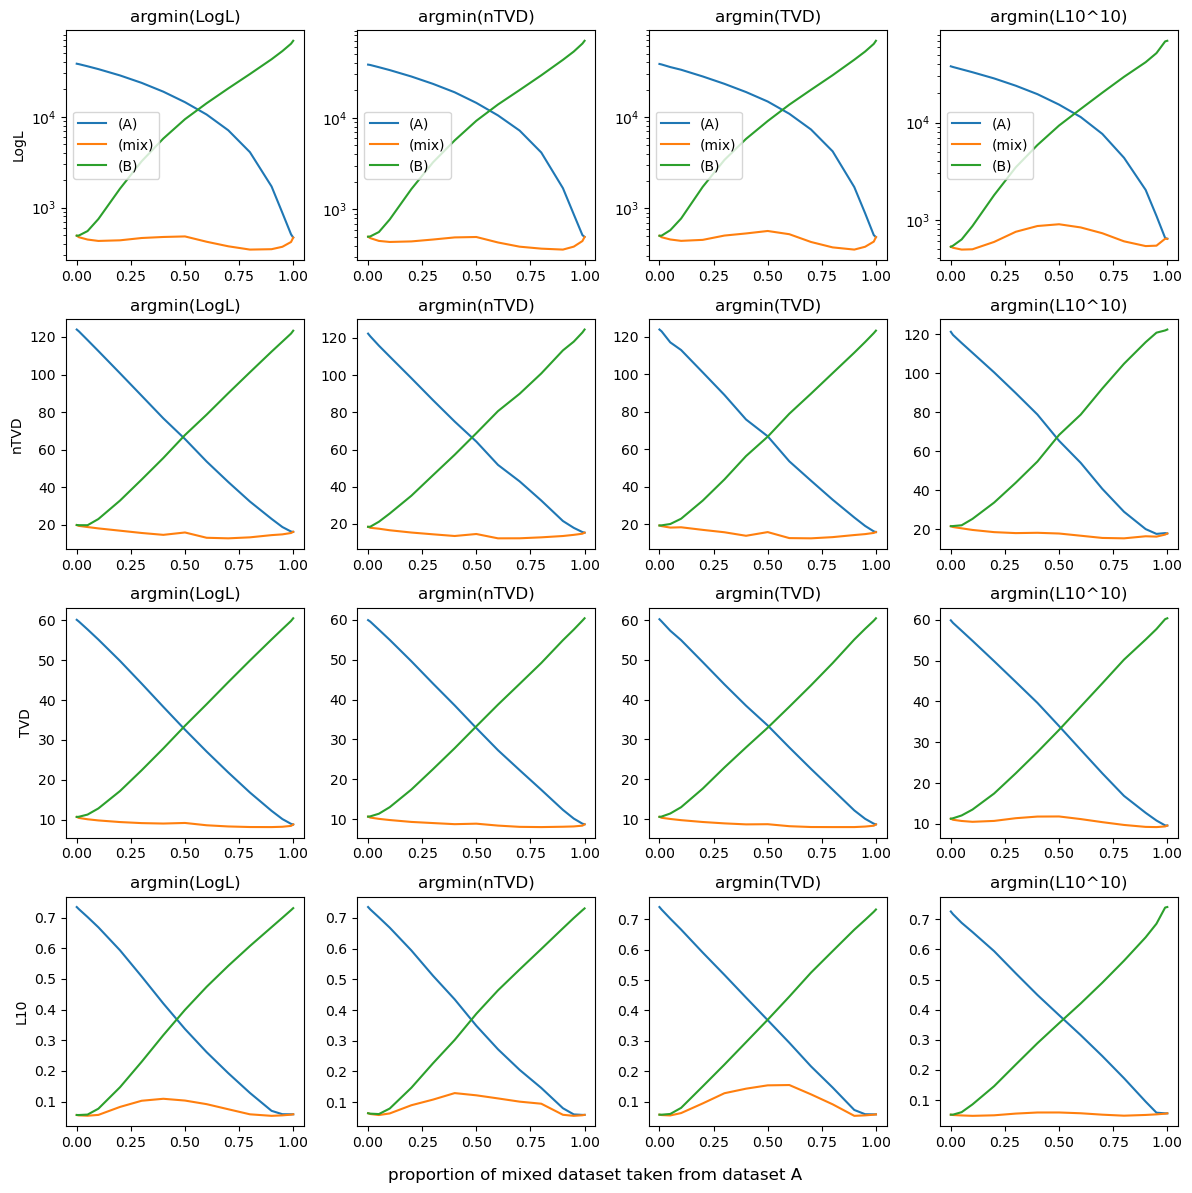

In [41]:
from matplotlib import pyplot as plt

fig, outer_axs = plt.subplots(4, 4, figsize=(12,12))
for i,metricname in enumerate(['LogL', 'nTVD', 'TVD', 'L10']):
    axs = outer_axs[i,:]
    for modelname, ax in zip(['argmin(LogL)', 'argmin(nTVD)', 'argmin(TVD)', 'argmin(L10^10)'], axs):
        rows = []
        datanames  = ['(A)', '(mix)', '(B)'] 
        for df in dflist:
            row = [ df[metricname + dataname][modelname] for dataname in datanames ]
            rows.append(row)
        y = np.array(rows)
        x = mixture_weights.copy()
        ax.plot(x,y)
        if metricname == 'LogL':
            ax.set_yscale('log')
            ax.legend(datanames)
        ax.set_title(modelname)
        if modelname == 'argmin(LogL)':
            ax.set_ylabel(metricname)
fig.supxlabel('proportion of mixed dataset taken from dataset A')
fig.tight_layout()


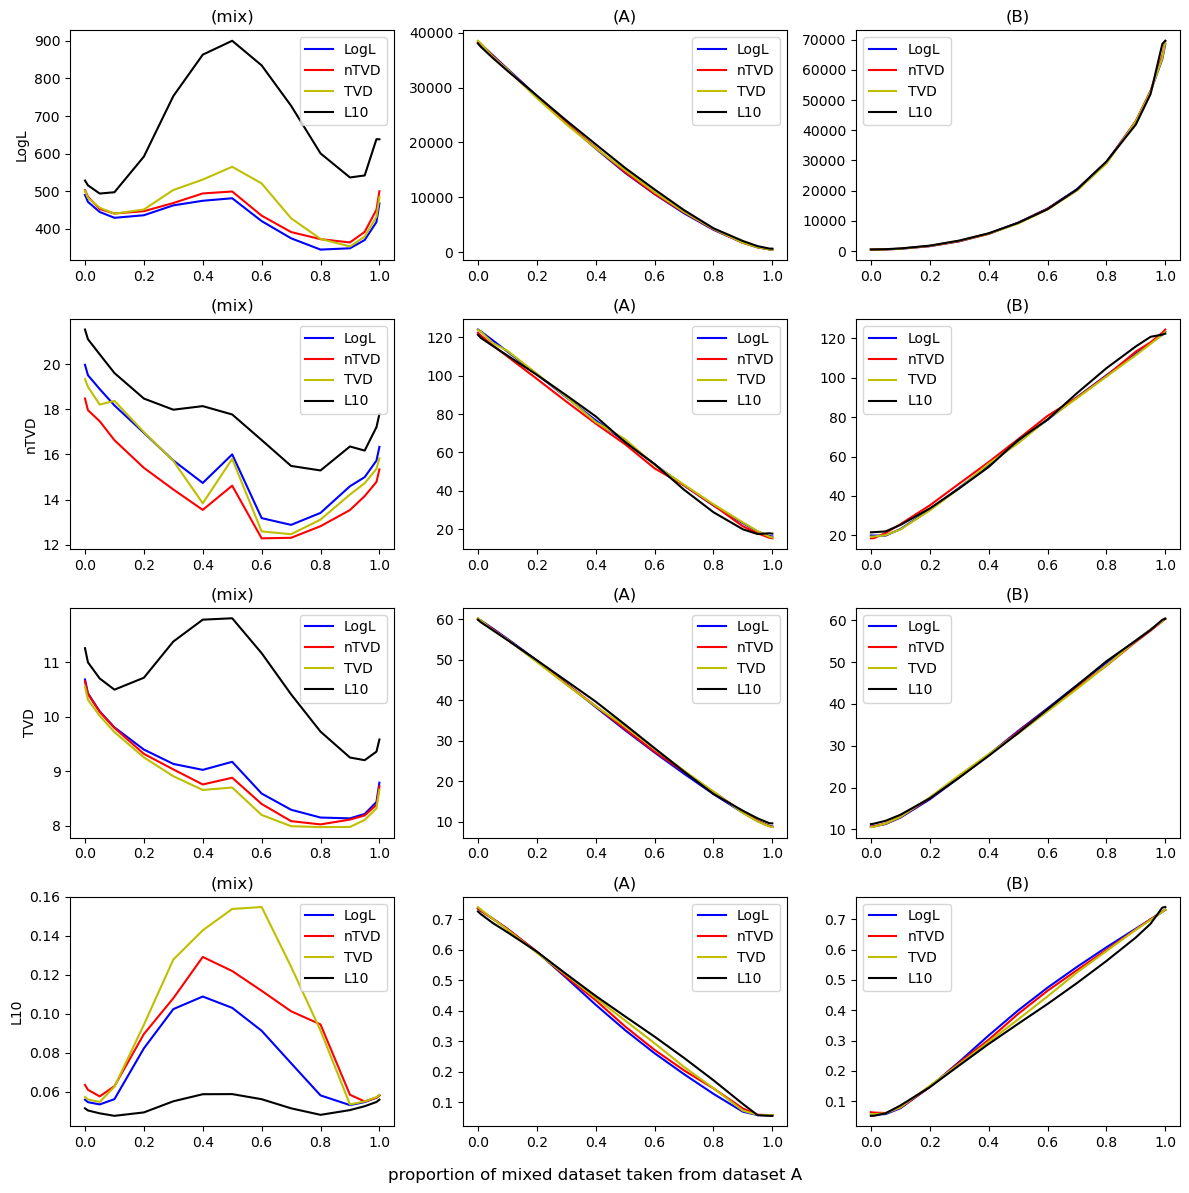

In [53]:
datanames  = [ '(mix)', '(A)', '(B)'] 
modelnames = ['argmin(LogL)', 'argmin(nTVD)', 'argmin(TVD)', 'argmin(L10^10)']
lossnames  = ['LogL', 'nTVD', 'TVD', 'L10']
losscolors = ['b', 'r', 'y', 'k']
fig, outer_axs = plt.subplots(len(lossnames), len(datanames), figsize=(12,12))
for i,metricname in enumerate(lossnames):
    axs = outer_axs[i,:]
    for dataname, ax in zip(datanames, axs):
        rows = []
        for df in dflist:
            row = [ df[metricname + dataname][modelname] for modelname in modelnames ]
            rows.append(row)
        y = np.array(rows)
        x = mixture_weights.copy()
        for i,yi in enumerate(y.T):
            ax.plot(x,yi,losscolors[i])
        if metricname == 'LogL':
            pass
            #ax.set_yscale('log')
        ax.legend(lossnames)
        ax.set_title(dataname)
        if dataname == '(mix)':
            ax.set_ylabel(metricname)
fig.supxlabel('proportion of mixed dataset taken from dataset A')
fig.tight_layout()

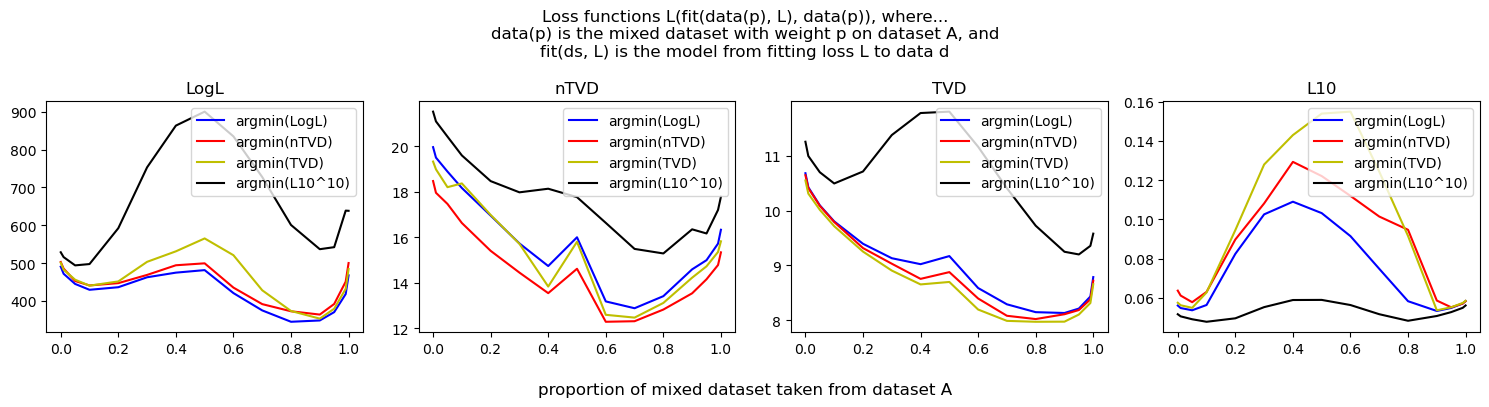

In [75]:
# datanames  = [ '(mix)', '(A)', '(B)'] 
modelnames = ['argmin(LogL)', 'argmin(nTVD)', 'argmin(TVD)', 'argmin(L10^10)']
lossnames  = ['LogL', 'nTVD', 'TVD', 'L10']
losscolors = ['b', 'r', 'y', 'k', 'd','.']
dataname = '(mix)'
fig, outer_axs = plt.subplots(1, len(lossnames), figsize=(15,4))
for metricname,ax in zip(lossnames, outer_axs):
    rows = []
    for df in dflist:
        row = [ df[metricname + dataname][modelname] for modelname in modelnames ]
        rows.append(row)
    y = np.array(rows)
    x = mixture_weights.copy()
    for i,yi in enumerate(y.T):
        ax.plot(x,yi,losscolors[i])
    ax.legend(modelnames)
    # ax.set_title(dataname)
    ax.set_title(metricname)
    # if dataname == '(mix)':
    #     ax.set_ylabel(metricname)
fig.suptitle('Loss functions L(fit(data(p), L), data(p)), where...\ndata(p) is the mixed dataset with weight p on dataset A, and\nfit(ds, L) is the model from fitting loss L to data d')
fig.supxlabel('proportion of mixed dataset taken from dataset A')
fig.tight_layout()